In [24]:
import numpy as np
from numpy import sin,cos,exp,tan,log,log10

import scipy as s
from scipy.integrate import odeint
from scipy import pi

import matplotlib.pyplot as plt

import os
import time
import inspect


In [40]:
# physical parameters

reduce_g = 0.2 # reduce g in order to see radial oscillations in a shorter tube with shorter time !!!
g = reduce_g * 9.81   # gravity acceleration (N/kg)

a = 0.05   # radius of tube (m)
H = 0.5  # length of tube (m)
h = 0.01   # thickness of tube (m)
sigma = 5.92e7   # conductivity of tube material (Siemens)
mu = 4*pi*1e-7   # magnetic permeability
m = 2   # dipole moment (A/m^2)
M = 0.0030   # mass of magnet (kg)
I = 1e-6   # moment of intertia of magnet (kg*m^2)




# simulation parameters

t_max = 2
max_iter = 200   # total number of iterations in time
dt = t_max/max_iter

init_height = -0.0*H # setting the initial condition z[0]
init_displ = 0.2*a  # setting the initial condition x[0]
init_angle = 0.1

N = 100  # number of ring partitions of tube
dH = H/N   # height of one ring
R = 2*pi*a/(sigma*h*dH)   # resistance of one ring (Ohm)
Z_ring = -(np.arange(N)+1/2) * dH   # array that stores effective positions of rings (midpoints in z)
#print(Z_ring)




# initiate arrays that store our data

T = np.linspace(0,t_max,max_iter)   # array that stores all points in time 

z = np.zeros((max_iter))   # array that stores coordinates of magnet along cylindrical axis as time progresses
vz = np.zeros((max_iter))
az = np.zeros((max_iter))

x = np.zeros((max_iter))   # array that stores radial coordinates of magnet in x-z plane as time progresses
vx = np.zeros((max_iter))
ax = np.zeros((max_iter))

alpha = np.zeros((max_iter))   # array that stores the tilt of magnet in x-z plane as time progresses
d1_alpha = np.zeros((max_iter)) # angular velocity
d2_alpha = np.zeros((max_iter)) # angular acceleration

J = np.zeros((max_iter, N))  # array that stores currents (in Amperes) in all rings as time progresses
Fx = np.zeros((max_iter, N)) # array that stores lateral forces (in Newtons) from each ring as time progresses
Fz = np.zeros((max_iter, N)) # array that stores vertical forces (in Newtons) from each ring as time progresses
Gy = np.zeros((max_iter, N)) # array that stores torques (in Newtons*metres) from each ring as time progresses






# file storage settings - this will be used in code below/next cell, when performing the data storage after simulation

folder = "python_arrays_nonparallel_magnet_leapfrog"
seed = 2  # parameter to create file name (it starts with this integer number)
# relevant values of seed:
# 1 - initial few investigations

# now create simulation-specific subfolder in "folder" so that path = folder/"subfolder"
path = os.path.join(folder,  '{}_N{}_iter{}_t{}_I{}'.format(seed,  N, max_iter, t_max, I))
print(path)
os.mkdir(path)

# these lists contain info about which variables to store in which ways (more below/next cell)
stored_arrays = [x,vx,z,vz,J,alpha,d1_alpha]
variables = [reduce_g,g,a,H,h,sigma,mu,m,M,I]
settings = [t_max,max_iter,dt,init_height,init_displ,init_angle,N,dH,R,folder,seed]






# definition of key functions

def Bz_loop(x, z, J):
    """This function calculates the z-component of magnetic field at coordinates (x,0,z), from a loop of radius a in x-y plane,
    , it is used for torque evaluation """
    u = x/a
    v = z/a
    return mu/4/pi * J / a * s.integrate.quad(lambda phi: (1 - u*cos(phi)) / (1 + u**2 + v**2 -2*u*cos(phi))**(3/2), 0, 2*pi)[0]

def Bx_loop(x, z, J):
    """This function calculates the x-component of magnetic field at coordinates (x,0,z), from a loop of radius a in x-y plane,
     , it is used for torque evaluation """
    u = x/a
    v = z/a
    return mu/4/pi * J  / a * s.integrate.quad(lambda phi: (v*cos(phi)) / (1 + u**2 + v**2 -2*u*cos(phi))**(3/2), 0, 2*pi)[0]

def torque_y(x, z, alpha, J):
    """This function calculates the y-component of torque on magnet at coordinates (x, 0, z) at tilt angle alpha,
    caused by magnetic field from loop in x-y plane of radius a. The underlying formula is Gy = mz*Bx - mx*Bz"""
    return (m*cos(alpha)) * (Bx_loop(x, z, J)) - (m*sin(alpha)) * (Bz_loop(x, z, J))

    
    
def emf(x,z,vz, alpha):
    """This function calculates the e.m.f. by doing integral "v cross B" along the body of the ring, neglecting the vx component
    of motion, which is much smaller than vz component."""
    def Bx_dipmag(phi):
        return m * (3*z * cos(alpha) * (x - a*cos(phi))   +   1/2 * (a**2 + 4*x**2 - 2*z**2 - 8*a*x*cos(phi) + 
        3*a**2*cos(2*phi)) * sin(alpha) )      /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    def By_dipmag(phi):
        return -3 * a * m * (z*cos(alpha) + (x - a*cos(phi) * sin(alpha))) * sin(phi) / (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    integral =  s.integrate.quad(lambda phi: By_dipmag(phi)*sin(phi) + Bx_dipmag(phi)*cos(phi), 0, 2*pi )
    integral = integral[0]
    integral *=  mu/4/pi * vz * a
    return integral


def force_z(x,z,alpha,J):
    """This function calculates the z-component of the magnetic force acting on  magnet at coordinates (x, 0, z) at tilt angle alpha,
    from an elemental ring in x-y plane of radius a, argument z interpreted in code as z(magnet) - z_ring.
    Two contributions: Fz = mz*dBz/dz + mx*dBz/dx = integral_z + integral_x"""
    u = x/a
    v = z/a
    integral_z = s.integrate.quad(lambda phi: v * (1 - u*cos(phi)) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_z = integral_z[0]
    integral_z *= + 3 * mu/4/pi * m * cos(alpha) / a**2 * J  # check the sign here!
    integral_x = s.integrate.quad(lambda phi: (-3*u + (2+2*u**2-v**2)*cos(phi) - u*cos(phi)**2) / (1 + u**2 + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_x = integral_x[0]
    integral_x *= +  mu/4/pi * m * sin(alpha) / a**2 * J
    return integral_x + integral_z
    
def force_x(x,z,alpha,J):
    """This function calculates the x-component of the magnetic force acting on  magnet at coordinates (x, 0, z) at tilt angle alpha,
    from an elemental ring in x-y plane of radius a, argument z interpreted in code as z(magnet) - z_ring.
    Two contributions: Fx = mz*dBx/dz + mx*dBx/dx = integral_z + integral_x"""
    u = x/a
    v = z/a
    integral_z = s.integrate.quad(lambda phi: cos(phi) * (1 + u**2  - 2*v**2 - 2*u*cos(phi)) / (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_z = integral_z[0]
    integral_z *= +  mu/4/pi * m*cos(alpha) / a**2 * J
    integral_x = s.integrate.quad(lambda phi: cos(phi) * (u - cos(phi))/ (1 + u**2  + v**2 - 2*u*cos(phi))**(5/2), 0, 2*pi)
    integral_x = integral_x[0]
    integral_x *= - 3 * v *  mu/4/pi * m*sin(alpha) / a**2 * J
    return integral_x + integral_z




python_arrays_nonparallel_magnet_leapfrog/2_N100_iter200_t2_I1e-06


FileExistsError: [Errno 17] File exists: 'python_arrays_nonparallel_magnet_leapfrog/2_N100_iter200_t2_I1e-06'

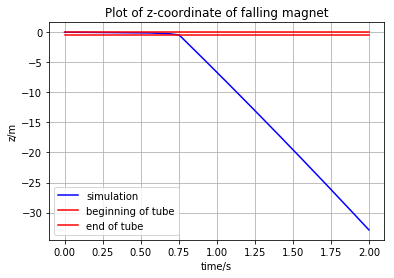

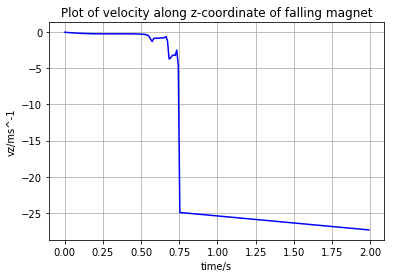

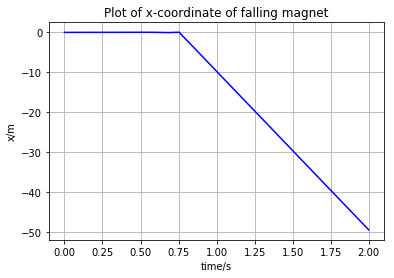

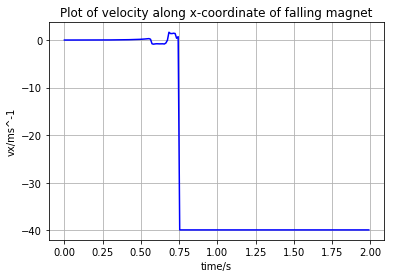

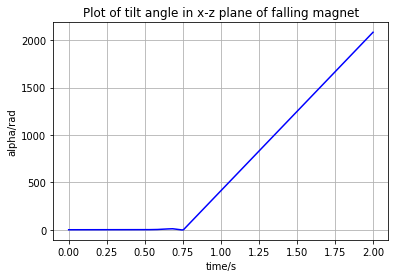

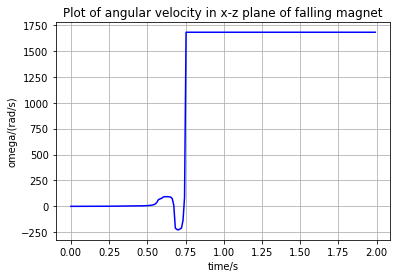

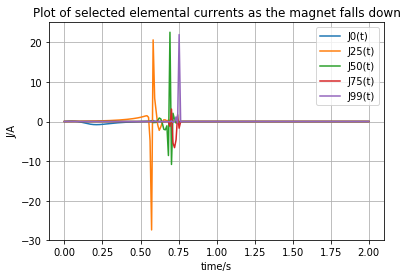

final coordinate of magnet, in cm: -3288.05
and in case of free fall, in cm:   -392.40

simulation took 40.79 s


In [41]:

# now implement ICs to get values for first two iterations

z[0] = init_height
az[0] = -g
vz[0] = 1/2*dt*az[0] # vz[0] is in fact vz[1/2], all indices for velocity are shifted forwards by 1/2
z[1] = z[0] + vz[0]*dt

x[0] = init_displ
ax[0] = 0
vx[0] = 1/2*dt*ax[0] # vx[0] is in fact vx[1/2], all indices for velocity are shifted forwards by 1/2
x[1] = x[0] + vx[0]*dt

alpha[0] = init_angle
d2_alpha[0] = 0
d1_alpha[0] = 1/2*dt*d2_alpha[0] # d1_alpha[0] is in fact d1_alpha[1/2], all indices for angularvelocity are shifted forwards by 1/2
alpha[1] = alpha[0] + d1_alpha[0]*dt

J[0,:] = 0
for n in range(N):
    J[1,n] = 1/R * emf(x[1],z[1]-Z_ring[n],vz[0]+1/2*dt*az[0],alpha[1])  # use extrapolated velocity between V[1/2] and V[3/2] to approximate V[1]



# solve using an improved first order finite difference approach "x[t+dt] = x[t] + dt*x'[t+1/2*dt]"

sim_start = time.time()

for i in range(1,max_iter-1):
        
    for n in range(N):  # quite stupid way, should later vectorize, but probably would not make much difference,
                        # as looping is likely negligible compared to all these horrible numerical integrations
        Fx[i,n] = force_x(x[i], z[i]-Z_ring[n], alpha[i], J[i,n])
        Fz[i,n] = force_z(x[i], z[i]-Z_ring[n], alpha[i], J[i,n])
        Gy[i,n] = torque_y(x[i], z[i]-Z_ring[n], alpha[i], J[i,n])
        
    ax[i] = 1/M * np.sum(Fx[i,:])   # sum all forces corresponding to separate rings at iteration i
    az[i] = -g + 1/M * np.sum(Fz[i,:])
    d2_alpha[i] = 1/I * np.sum(Gy[i,:])
    
    vx[i] = vx[i-1] + ax[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    vz[i] = vz[i-1] + az[i]*dt   # e.g. for i=1: V[3/2] = V[1/2] + A[1]*dt
    d1_alpha[i] = d1_alpha[i-1] + d2_alpha[i]*dt
    
    x[i+1] = x[i] + vx[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    z[i+1] = z[i] + vz[i]*dt   # e.g. for i=1: Z[2] = Z[1] + V[3/2]*dt
    alpha[i+1] = alpha[i] + d1_alpha[i]*dt
    
    for n in range(N):
        J[i+1,n] = 1/R * emf(x[i+1], z[i+1]-Z_ring[n],vz[i]+1/2*dt*az[i], alpha[i+1]) # e.g. for i=1: J[2] = f( Z[2], V[3/2]+A[2]*1/2*dt )

sim_end = time.time()



# customize which part of plot to show - if cut_fraction = 0.8, then only display first 80 % of the simulation
 
def plot_graphs(cut_fraction):
    end = int(cut_fraction * max_iter)
    
    plt.plot(T[:end],z[:end],'b',label='simulation')
    #plt.plot(T,init_height-1/2*g*T**2,'g',label='free fall')
    plt.plot(T[:end], 0*np.ones(len(T[:end])),'r', label='beginning of tube')
    plt.plot(T[:end], -H*np.ones(len(T[:end])),'r', label='end of tube')
    plt.legend()
    plt.xlabel('time/s')
    plt.ylabel('z/m')
    plt.title('Plot of z-coordinate of falling magnet')
    plt.grid()
    plt.show()

    plt.plot(T[:(-1+end)],vz[:(-1+end)],'b')
    plt.xlabel('time/s')
    plt.ylabel('vz/ms^-1')
    plt.title('Plot of velocity along z-coordinate of falling magnet')
    plt.grid()
    plt.show()

    plt.plot(T[:end],x[:end],'b',label='simulation')
    plt.xlabel('time/s')
    plt.ylabel('x/m')
    plt.title('Plot of x-coordinate of falling magnet')
    plt.grid()
    plt.show()

    plt.plot(T[:(-1+end)],vx[:(-1+end)],'b')
    plt.xlabel('time/s')
    plt.ylabel('vx/ms^-1')
    plt.title('Plot of velocity along x-coordinate of falling magnet')
    plt.grid()
    plt.show()

    plt.plot(T[:end],alpha[:end],'b',label='simulation')
    plt.xlabel('time/s')
    plt.ylabel('alpha/rad')
    plt.title('Plot of tilt angle in x-z plane of falling magnet')
    plt.grid()
    plt.show()

    plt.plot(T[:(-1+end)],d1_alpha[:(-1+end)],'b')
    plt.xlabel('time/s')
    plt.ylabel('omega/(rad/s)')
    plt.title('Plot of angular velocity in x-z plane of falling magnet')
    plt.grid()
    plt.show()

    for k in [0, N//4, N//2, 3*N//4, N-1]:
        plt.plot(T[:end], J[:end,k], label='J'+str(k)+'(t)')
    plt.xlabel('time/s')
    plt.ylabel('J/A')
    plt.legend()
    plt.title('Plot of selected elemental currents as the magnet falls down')
    plt.grid()
    plt.show()

#first plot the default case - the entire time range of simulation
plot_graphs(1)   




# this section is concerned with creating files in which to store the outcomes

def retrieve_name(var):
    """https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string"""
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

# at the top of this notebook/file are settings like e.g.:
#stored arrays = [x,vx,z,vz,J,alpha,d1_alpha]
#variables = [reduce_g,g,a,H,h,sigma,mu,m,M,I]
#settings = [t_max,max_iter,dt,init_height,init_displ,init_angle,N,dH,R]

# save the data in separate files with arrays of corresponding physical quantities inside specific folder
# name of file is indicative of content (thought not exhaustive of all specifications), as below:

for array in stored_arrays:
    np.savetxt('{}/{}_{}_N{}_iter{}_t{}_I{}'.format(path, seed, retrieve_name(array)[0], N, max_iter, t_max, I), array)

# and finally create a file with overall description of the simulation
infoFileName = '{}/{}_info_N{}_iter{}_t{}_I{}'.format(path, seed, N, max_iter, t_max, I)

f = open(infoFileName, "w")
f.write("simulation run on "+str(time.asctime( time.localtime(time.time()) ))+'\n')
f.write("simulation took "+"{:.2f}".format(sim_end-sim_start)+" s"+'\n')
f.write('\n')
f.write("physical parameters:"+'\n')
for var in variables:
    f.write(retrieve_name(var)[0]+" = "+str(var)+'\n')
f.write('\n')
f.write("simulation parameters:"+'\n')
for setting in settings:
    f.write(retrieve_name(setting)[0]+" = "+str(setting)+'\n')
f.write("\n")
f.close()


print("final coordinate of magnet, in cm:","{:.2f}".format(z[-1]*100))
print("and in case of free fall, in cm:  ","{:.2f}".format((init_height-1/2*g*T[-1]**2)*100))
print()
print("simulation took","{:.2f}".format(sim_end-sim_start),"s")


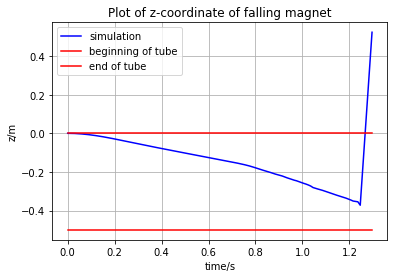

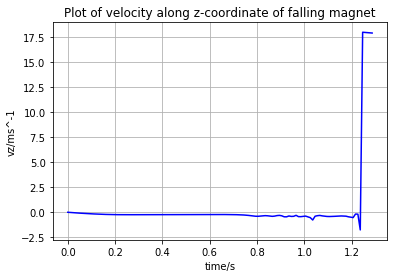

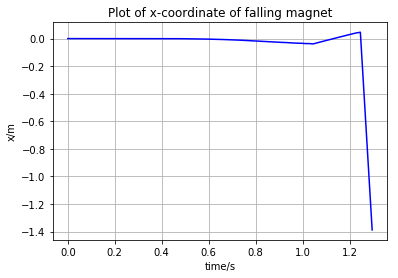

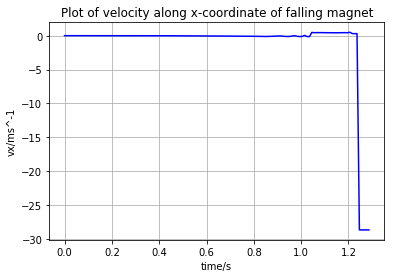

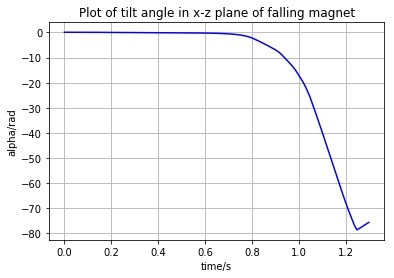

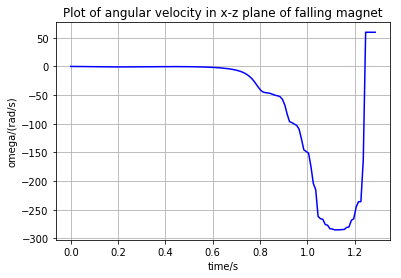

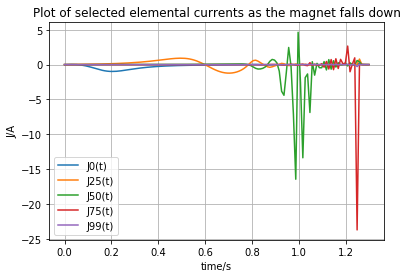

In [10]:
plot_graphs(0.65)

In [ ]:

# investigate the spatial dependence of forces at one fixed value of angle

alpha_fix = 0.2 # when investigating quantity(x or z) at alpha=const.
x_fix = round(0.2*a,3)  # when investigating quantity(z) at x=const.,alpha=const.
z_fix = 1*a    # when investigating quantity(x) at z=const.,alpha=const.
J = 1  # fix current to be 1 Ampere

gridlength = 200
X = np.linspace(0, 3*a, gridlength)   # range of x-values, when they are varied...
Z = np.linspace(0,3*a,gridlength)   # range of z-values, when they are varied...
Alpha = np.linspace(0,2*pi,gridlength)   # # range of alpha-values, when they are varied...
Fx_x, Fx_z, Fz_x, Fz_z = np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength), np.zeros(gridlength)


for i in range(gridlength):
    Fx_x[i] = force_x(X[i], z_fix, alpha_fix, J)
    Fx_z[i] = force_x(x_fix, Z[i], alpha_fix, J)
    Fz_x[i] = force_z(X[i], z_fix, alpha_fix, J)
    Fz_z[i] = force_z(x_fix, Z[i], alpha_fix, J)

plt.plot(X/a, Fx_x, label="Fx(x)")
plt.plot(X/a, Fz_x, label="Fz(x)")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.grid()
plt.title("Radial and axial forces as functions of radial coordinate x, at z = "+str(z_fix/a)+" a, alpha = "+str(alpha_fix))
plt.xlabel('x/a')
plt.ylabel('F/N')
plt.show()

plt.plot(Z/a, Fx_z, label="Fx(z)")
plt.plot(Z/a, Fz_z, label="Fz(z)")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.grid()
plt.title("Radial and axial forces as functions of axial coordinate z , at x = "+str(round(x_fix/a,3))+" a, alpha = "+str(alpha_fix))
plt.xlabel('z/a')
plt.ylabel('F/N')
plt.show()


# investigate the spatial dependence of d_phi_mag / d_z , which corresponds to e.m.f. for vz = 1 m/s

gridlength = 400
X = np.linspace(-2*a, 2*a, gridlength)
Z = np.linspace(-2*a,2*a,gridlength)
x_fix, z_fix = 0.2*a , 1*a
emf_x, emf_z = np.zeros(gridlength), np.zeros(gridlength)
J = 1

for i in range(gridlength):
    
    emf_x[i] = emf(X[i], z_fix, 1)
    emf_z[i] = emf(x_fix, Z[i], 1)

plt.plot(X/a, emf_x, label="emf(x)")
plt.plot(X/a, 0*X,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of radial coordinate x, at z = " + str("{:.1f}".format(z_fix/a)) + "a, and unit J, vz")
plt.xlabel('x/a')
plt.ylabel('emf/V')
plt.show()

plt.plot(Z/a, emf_z, label="emf(z)")
plt.plot(Z/a, 0*Z,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of axial coordinate z, at x = " + str("{:.1f}".format(x_fix/a)) + "a, and unit J, vz")
plt.xlabel('z/a')
plt.ylabel('emf/V')
plt.show()


In [ ]:
# investigate the spatial dependence of forces for a range of angles

x_fix = round(0.2*a,3)  # when investigating quantity(z) at x=const.,alpha=const.
z_fix = 1*a    # when investigating quantity(x) at z=const.,alpha=const.
J = 1  # fix current to be 1 Ampere

gridlength = 200
Alpha = np.array((0,0.8,pi/2,pi-0.8,pi))
num_angles = len(Alpha)
X = np.linspace(-a, 3*a, gridlength)   # range of x-values, when they are varied...
Z = np.linspace(-a,3*a,gridlength)   # range of z-values, when they are varied...
Fx_x = np.zeros((num_angles,gridlength))  
Fx_z = np.zeros((num_angles,gridlength))  # dependence of x-th component of force on z-coordinate
Fz_x = np.zeros((num_angles,gridlength))
Fz_z = np.zeros((num_angles,gridlength))

for k in range(num_angles): 
    for i in range(gridlength):
        Fx_x[k,i] = force_x(X[i], z_fix, Alpha[k], J)
        Fx_z[k,i] = force_x(x_fix, Z[i], Alpha[k], J)
        Fz_x[k,i] = force_z(X[i], z_fix, Alpha[k], J)
        Fz_z[k,i] = force_z(x_fix, Z[i], Alpha[k], J)
        


for k in range(num_angles):
    plt.plot(X/a, Fx_x[k,:], label=str(round(Alpha[k],2))+" rad")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.grid()
plt.title("Radial force Fx as function of radial coordinate x, at z = "+str(z_fix/a)+" a, for a range of angles and J=+1A")
plt.xlabel('x/a')
plt.ylabel('F/N')
plt.show()

for k in range(num_angles):
    plt.plot(X/a, Fz_x[k,:], label=str(round(Alpha[k],2))+" rad")
plt.plot(X/a, 0*X,'k')
plt.legend()
plt.grid()
plt.title("Vertical force Fz as function of radial coordinate x, at z = "+str(z_fix/a)+" a, for a range of angles and J=+1A")
plt.xlabel('x/a')
plt.ylabel('F/N')
plt.show()


for k in range(num_angles):
    plt.plot(Z/a, Fx_z[k,:], label=str(round(Alpha[k],2))+" rad")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.grid()
plt.title("Radial force Fx as function of vertical coordinate z , at x = "+str(round(x_fix/a,3))+" a, for a range of angles and J=+1A")
plt.xlabel('z/a')
plt.ylabel('F/N')
plt.show()

for k in range(num_angles):
    plt.plot(Z/a, Fz_z[k,:], label=str(round(Alpha[k],2))+" rad")
plt.plot(Z/a, 0*Z, 'k')
plt.legend()
plt.grid()
plt.title("Vertical force Fz as function of vertical coordinate z , at x = "+str(round(x_fix/a,3))+" a, for a range of angles and J=+1A")
plt.xlabel('z/a')
plt.ylabel('F/N')
plt.show()




# investigate the spatial dependence of d_phi_mag / d_z , which corresponds to e.m.f. for vz = 1 m/s

gridlength = 400
X = np.linspace(-2*a, 2*a, gridlength)
Z = np.linspace(-2*a,2*a,gridlength)
x_fix, z_fix = 0.2*a , 1*a
emf_x, emf_z = np.zeros(gridlength), np.zeros(gridlength)
J = 1

for i in range(gridlength):
    
    emf_x[i] = emf(X[i], z_fix, 1)
    emf_z[i] = emf(x_fix, Z[i], 1)
    


plt.plot(X/a, emf_x, label="emf(x)")
plt.plot(X/a, 0*X,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of radial coordinate x, at z = " + str("{:.1f}".format(z_fix/a)) + "a, and unit J, vz")
plt.xlabel('x/a')
plt.ylabel('emf/V')
plt.show()

plt.plot(Z/a, emf_z, label="emf(z)")
plt.plot(Z/a, 0*Z,'k')
#plt.legend()
plt.grid()
plt.title("e.m.f. as function of axial coordinate z, at x = " + str("{:.1f}".format(x_fix/a)) + "a, and unit J, vz")
plt.xlabel('z/a')
plt.ylabel('emf/V')
plt.show()

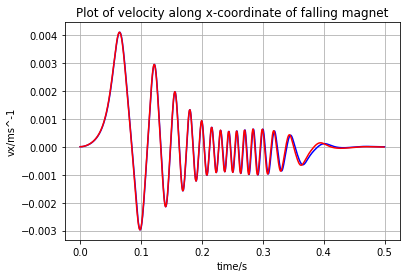

In [72]:
# this cell loads data for a W. Mathematica and Python simulation(s) 
# in order to plot trajectories and physical properties of falling magnet
# if comparing WM and Py one should check that physical and simulation parameters agree!!!

# modify simulation parameters in filename, the file containing array of datapoint for indicated variable
# with corresponding simulation is then loaded (if exists!)

# adapted to also compare two Python simulations together!
# simply manually overwrite the parameters that are needed
# common parameters in filename for both sim. 1 and 2 (one of them in fact not in common, see later):
folder, seed, N, max_iter, t_max, init_angle = 'python_arrays_nonparallel_onaxis', 2, 100, 5000, 0.5, 0.1

# change to relevant parameter of simulation 1:
max_iter = 5000
X_py1 = np.genfromtxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vx_py1 = np.genfromtxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Z_py1 = np.genfromtxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vz_py1 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
alpha_py1 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))

# change to relevant parameter of simulation 2:
max_iter = 500
X_py2 = np.genfromtxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vx_py2 = np.genfromtxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Z_py2 = np.genfromtxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
Vz_py2 = np.genfromtxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle))
alpha_py2 = 
# need to enter manually the length of both Python simulations
T1 = np.linspace(0,0.5,5000)
T2 = np.linspace(0,0.5,500)

# likewise for Mathematica files
#X_wm = np.genfromtxt("mathematica_arrays/sim1_U.dat")
#Z_wm = np.genfromtxt("mathematica_arrays/sim1_Z.dat")


"""
# here, we can plot the trajectory in space

plt.figure(figsize=(10,10))
plt.plot(X_py1, Z_py1, 'b', label='simulation in Python #1')
plt.plot(X_py2, Z_py2, 'g', label='simulation in Python #2')
#plt.plot(X_wm, Z_wm, 'y', label='simulation in Mathematica')  # only relevant for a choice of parameters
plt.plot([-a,+a], [-H,-H],'r--', label='tube wall')
plt.plot([-a,+a], [0,0],'r--')
plt.plot([-a,-a], [0, -H], 'r')
plt.plot([+a,+a], [0, -H], 'r')
plt.plot([0,0], [0, -H], 'k--')
plt.xlabel('x/m')
plt.ylabel('z/m')
plt.legend()
plt.title('Plot of spatial trajectory of falling magnet')
plt.grid()
plt.show()
"""

plt.plot(T1[:-1],Vx_py1[:-1],'b')
plt.plot(T2[:-1],Vx_py2[:-1],'r')
plt.xlabel('time/s')
plt.ylabel('vx/ms^-1')
plt.title('Plot of velocity along x-coordinate of falling magnet')
plt.grid()
plt.show()

plt.plot(T,alpha,'b',label='simulation')
plt.xlabel('time/s')
plt.ylabel('alpha/rad')
plt.title('Plot of tilt angle in x-z plane of falling magnet')
plt.grid()
plt.show()

In [ ]:

# Old/discarded/miscallaneous code


def Bx(x, z,alpha,phi):
    """This function calculates the x-component of magnetic field from a magnet at [x,0,z] tilted at angle alpha
    at a line element with azimuthal angle phi, of a ring in x-y plane """ 
    Bx = m * (3*z * cos(alpha) * (x - a*cos(phi))   +   1/2 * (a**2 + 4*x**2 - 2*z**2 - 8*a*x*cos(phi) + 
      3*a**2*cos(2*phi)) * sin(alpha) )      /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    return Bx

def By(x, z, alpha, phi):
    """This function calculates the y-component of magnetic field from a magnet at [x,0,z] tilted at angle alpha
    at a line element with azimuthal angle phi, of a ring in x-y plane """ 
    By = -3 * a * m * (z*cos(alpha) + (x - a*cos(phi) * sin(alpha)) * sin(phi)    /      (a**2 + x**2 + z**2 - 2 *a *x *cos(phi)) ** (5/2)
    return By

#def saveArrays(folder, seed, variable, N, max_iter, t_max, alpha):
#    np.savetxt('{}/{}_'+str(variable)'_N{}_iter{}_t{}_alpha{}'.format(folder, seed, N, max_iter, t_max), x)


#folder = 'python_arrays_nonparallel_onaxis'

#for variable in [x,vx,z,vz,J]:
#    np.savetxt(getName[variable].format(folder, seed, N, max_iter, t_max), variable)
                       
                       
np.savetxt('{}/{}_x_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), x)
np.savetxt('{}/{}_vx_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), vx)
np.savetxt('{}/{}_z_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), z)
np.savetxt('{}/{}_vz_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), vz)
np.savetxt('{}/{}_J_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), J)
np.savetxt('{}/{}_alpha_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), alpha)
np.savetxt('{}/{}_omega_N{}_iter{}_t{}_angle{}'.format(folder, seed, N, max_iter, t_max, init_angle), d1_alpha)


In [29]:
import inspect

superVar = np.array([2,2,2])
nextOne = 4

variables = [superVar, nextOne]

def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]
for var in variables:
    print(retrieve_name(var)[1],"=",var)
    
type(retrieve_name(nextOne)[1])

superVar = [2 2 2]
nextOne = 4


str

In [18]:
import time
time.asctime( time.localtime(time.time()) )

'Fri Sep 25 17:41:15 2020'

In [23]:
import os
directory="a"
parent_dir = "b"
path = os.path.join(parent_dir, directory)
print(path)

b/a
